In [33]:
from subprocess import Popen, PIPE, CalledProcessError
import ast
import matplotlib.pyplot as plt

In [12]:
def simulate(mean_arrival_time, mean_departure_time, servers, simulation_time):
    cmd = '.\cmake-build-debug\mmc_simulation.exe {} {} {} {} --verbose'.format(mean_arrival_time, mean_departure_time, servers, simulation_time)
    with Popen(cmd, stdout=PIPE, stderr=PIPE, bufsize=1, universal_newlines=True) as p:
        cout, cerr = p.communicate()
        if p.returncode != 0:
            raise CalledProcessError(p.returncode, p.args)
        cout = cout.split('\n')
        cerr = cerr.split('\n')
        statistics = ast.literal_eval('{'+''.join(elem+',' for elem in cout[:4])[:-1]+'}')
        if 'stationary probabilities for states' in cout[-2]:
            last_index = -2
        else:
            last_index = -1
        probabilities = ast.literal_eval('{'+''.join(elem+',' for elem in cout[5:last_index])[:-1]+'}')
        events = []
        for sample in cerr[1:-1]:
            time = sample[:sample.find(':')]
            sample = sample[len(time)+2:]
            what_happened = sample[:sample.find(',')]
            sample = sample[len(what_happened)+2:]
            what_happened = what_happened.split(' ')
            active_servers = sample[sample.find('- ')+2:sample.find('/')]
            event = dict([('time', float(time)), ('event', what_happened), ('active_servers', int(active_servers))])
            events.append(event)
        return statistics, probabilities, events

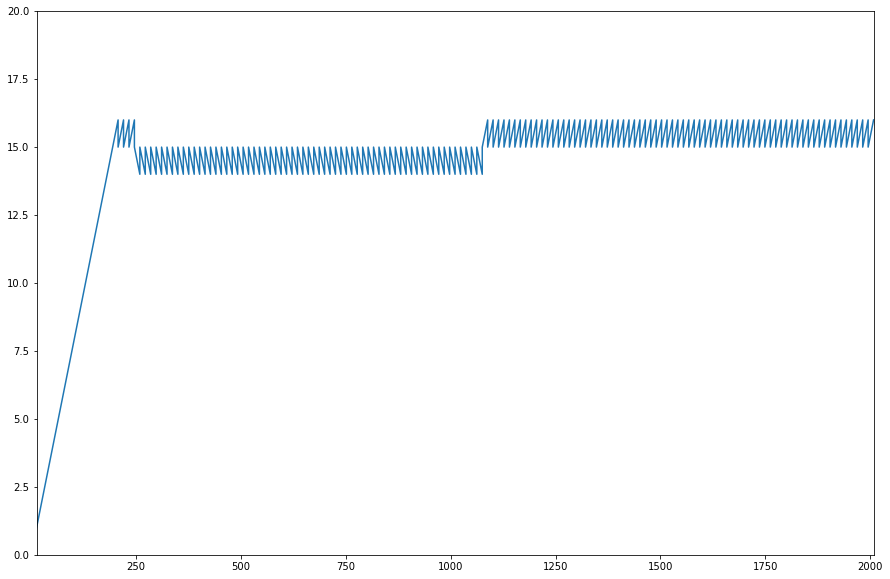

In [34]:
mean_arrival_time = 10
mean_departure_time = 150
servers = 20
simulation_time = 2000
statistics, probabilities, events = simulate(mean_arrival_time, mean_departure_time, servers, simulation_time)
time = [event['time'] for event in events]
active = [event['active_servers'] for event in events]
plt.figure(figsize=(15,10))
plt.plot(time, active)
plt.axis([min(time), max(time), 0, servers])
plt.show()

In [22]:
print(statistics)
print(probabilities)

{'total_time': 2000.0, 'served': 139, 'denied': 0, 'average_state': 14.6}
{0: 0.0034, 1: 0.0034, 2: 0.0034, 3: 0.0034, 4: 0.0034, 5: 0.0034, 6: 0.0034, 7: 0.0034, 8: 0.0034, 9: 0.0034, 10: 0.0034, 11: 0.0034, 12: 0.0034, 13: 0.0034, 14: 0.221, 15: 0.476, 16: 0.255}


In [23]:
for event in events[:3]:
    print(event)
print('...')
for event in events[-3:]:
    print(event)

{'time': 12.9554, 'event': ['arrival', 'accepted'], 'active_servers': 1}
{'time': 25.9107, 'event': ['arrival', 'accepted'], 'active_servers': 2}
{'time': 38.8661, 'event': ['arrival', 'accepted'], 'active_servers': 3}
...
{'time': 1995.13, 'event': ['arrival', 'accepted'], 'active_servers': 16}
{'time': 1995.13, 'event': ['departure'], 'active_servers': 15}
{'time': 2008.08, 'event': ['arrival', 'accepted'], 'active_servers': 16}
